# AIBL Baseline AD Classifier (Tabular)

This notebook builds a clean, reproducible baseline to predict **Alzheimer's Disease (AD)** at baseline from tabular AIBL data.

**Highlights**
- Deterministic train/validation split
- Robust preprocessing (label fixes, leakage-safe feature selection, scaling)
- Baselines: Logistic Regression
- Neural Net: MLPClassifier
- Proper metrics: Accuracy, ROC–AUC, classification report, confusion matrix
- Model & scaler persistence


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_CSV = "/home/kevin-koshy/PortfolioPROJECTS/aibl_merged_clean.csv"  # change this path if needed


Load & Inspect

In [4]:
df = pd.read_csv(DATA_CSV)
print(df.shape)
df.head()

print("Unique values in DXAD:", sorted(df["DXAD"].unique().tolist()))
print("Class counts (raw):")
print(df["DXAD"].value_counts(dropna=False))


(862, 36)
Unique values in DXAD: [-4, 1]
Class counts (raw):
DXAD
-4    757
 1    105
Name: count, dtype: int64


Cleaning / Label Fixes

In [5]:
df["DXAD"] = df["DXAD"].replace({-4: 0}).astype(int)
df = df.dropna(subset=["DXAD"]).copy()

print("Class counts after mapping -4->0:")
print(df["DXAD"].value_counts())


Class counts after mapping -4->0:
DXAD
0    757
1    105
Name: count, dtype: int64


Feature Selection & Split

In [6]:
drop_cols = [
    "RID","SITEID","SITEID_r","VISCODE","VISCODE_r","PTDOB","APTESTDT","EXAMDATE","EXAMDATE_r"
]
diag_cols = [c for c in df.columns if c.startswith("DX")]
feature_cols = [c for c in df.columns if c not in set(drop_cols + diag_cols + ["DXAD"])]

X = df[feature_cols].apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))

y = df["DXAD"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (689, 20)  Test shape: (173, 20)


Logistic Regression Baseline

LogReg -> Accuracy: 0.948 | ROC-AUC: 0.977
              precision    recall  f1-score   support

           0      0.961     0.980     0.971       152
           1      0.833     0.714     0.769        21

    accuracy                          0.948       173
   macro avg      0.897     0.847     0.870       173
weighted avg      0.946     0.948     0.946       173



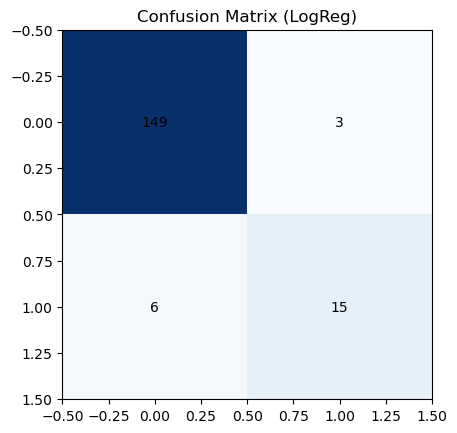

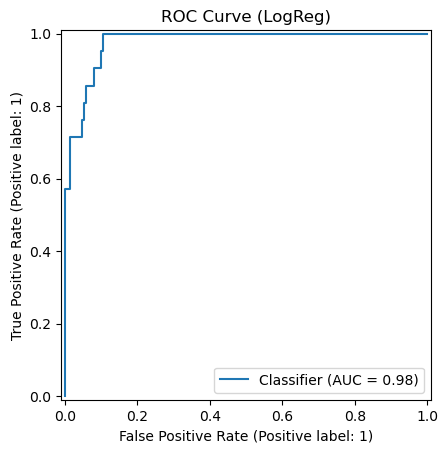

In [7]:
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
logreg.fit(X_train_sc, y_train)

y_pred_lr = logreg.predict(X_test_sc)
y_proba_lr = logreg.predict_proba(X_test_sc)[:, 1]

print(f"LogReg -> Accuracy: {accuracy_score(y_test, y_pred_lr):.3f} | ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")
print(classification_report(y_test, y_pred_lr, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (LogReg)")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC Curve (LogReg)")
plt.show()


Neural Net (MLPClassifier)

MLP -> Accuracy: 0.942 | ROC-AUC: 0.975
              precision    recall  f1-score   support

           0      0.961     0.974     0.967       152
           1      0.789     0.714     0.750        21

    accuracy                          0.942       173
   macro avg      0.875     0.844     0.859       173
weighted avg      0.940     0.942     0.941       173



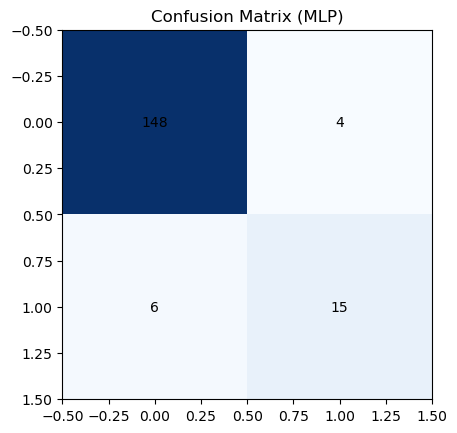

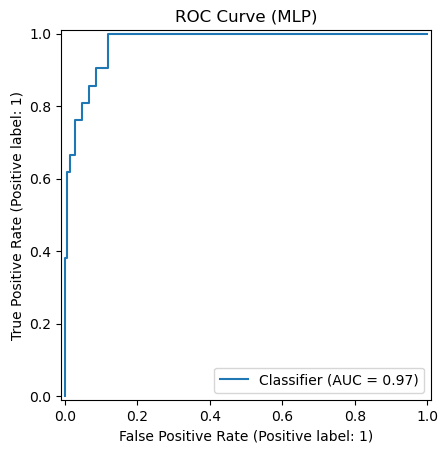

In [8]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=RANDOM_SEED,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)
mlp.fit(X_train_sc, y_train)

y_pred_mlp = mlp.predict(X_test_sc)
y_proba_mlp = mlp.predict_proba(X_test_sc)[:, 1]

print(f"MLP -> Accuracy: {accuracy_score(y_test, y_pred_mlp):.3f} | ROC-AUC: {roc_auc_score(y_test, y_proba_mlp):.3f}")
print(classification_report(y_test, y_pred_mlp, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (MLP)")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_mlp)
plt.title("ROC Curve (MLP)")
plt.show()


In [9]:
import joblib, os
out_dir = "./artifacts"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(scaler, os.path.join(out_dir, "scaler.joblib"))
joblib.dump(logreg, os.path.join(out_dir, "logreg.joblib"))
joblib.dump(mlp,    os.path.join(out_dir, "mlp.joblib"))

print("Models saved to ./artifacts")


Models saved to ./artifacts
